# Training Data Generation

The input images will be cut randomly into smaller pieces to train the neural network.

Press 'Run' (above) or Shift+Enter.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division

import numpy as np
import matplotlib.pyplot as plt
import os
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.data import RawData, create_patches
from csbdeep.io import load_training_data, load_training_data_direct
from csbdeep.models import Config, CARE
from csbdeep.data.transform import anisotropic_distortions, permute_axes

Using TensorFlow backend.


Please input the path to the big folder that contains the 'HighRes' and 'LowRes_' images in the box below.
Then press Enter

Folder Path? C:\Users\User\Desktop\Ensemble
Showing C1-DEP_TLR4Het_Pair1_Fem_P25_VG1-647_PSD95-568_ACC1_A01_G001_0001.tif
Image size = (15, 1024, 1024)


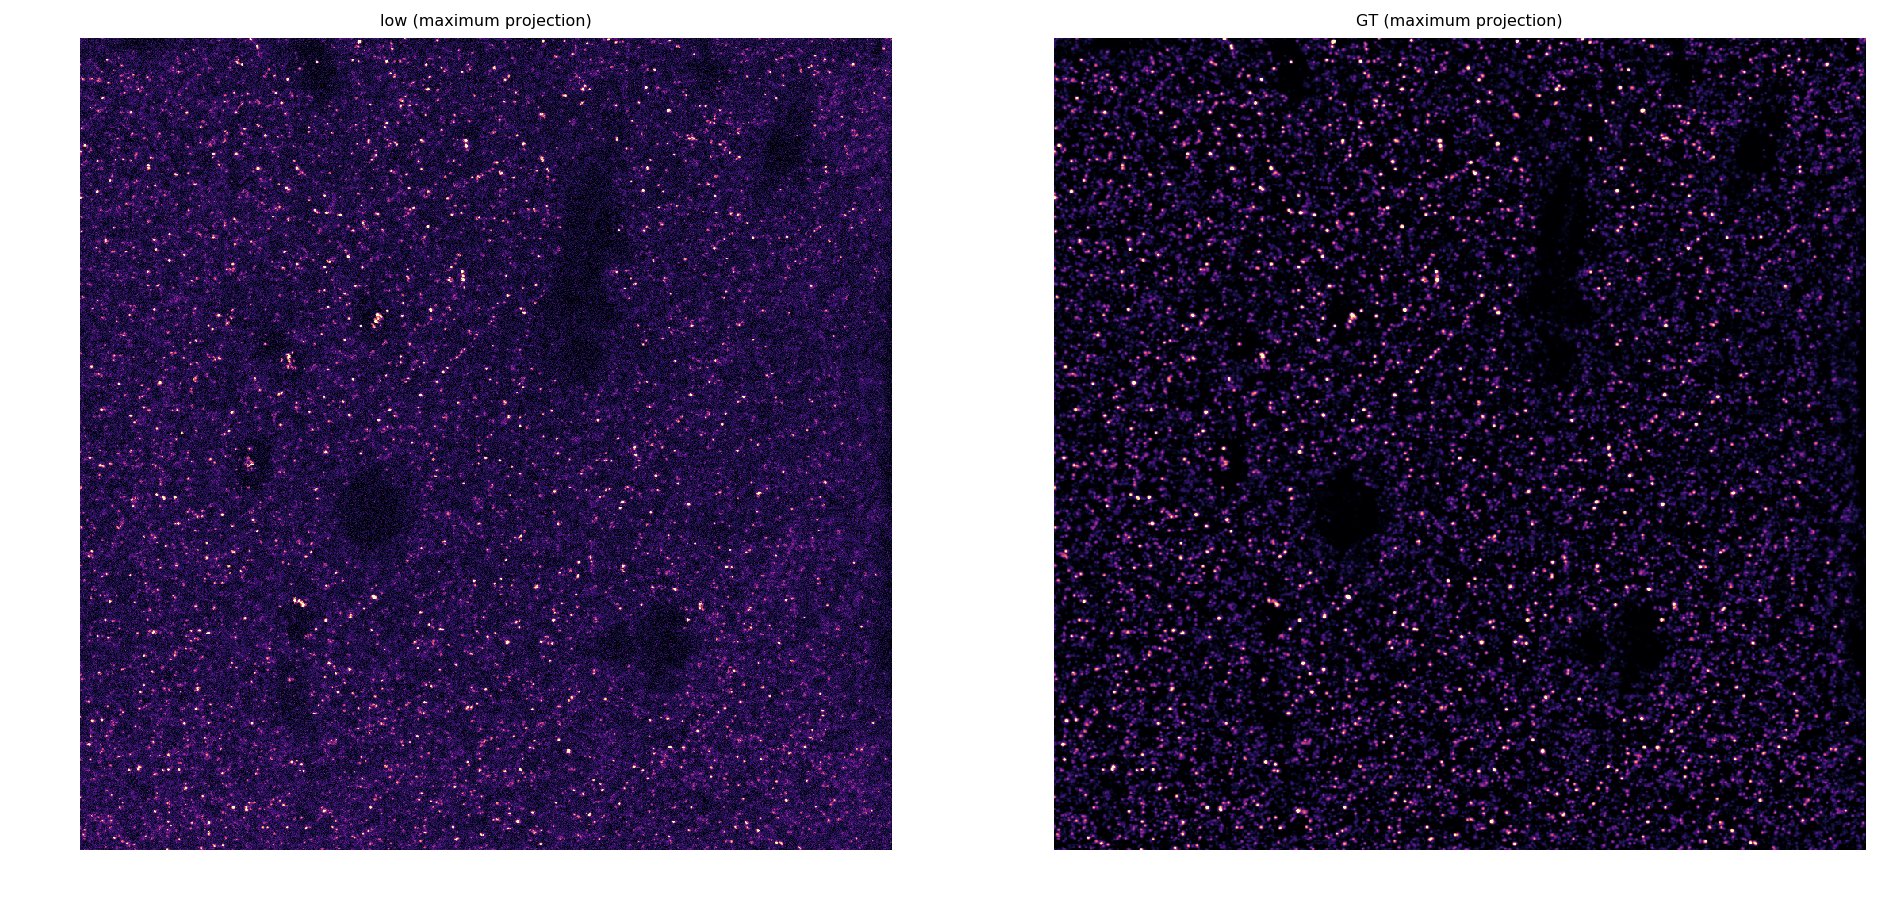

In [2]:
# Ask for folder path
print("Please input the path to the big folder that contains the 'HighRes' and 'LowRes_' images in the box below.")
print("Then press Enter\n")
name = input("Folder Path? ")
directory = name
highres   = '/HighRes/'
lowres    = '/LowRes1/'

# Look for first tif file
for file in os.scandir(directory + highres):
    if file.name.endswith(".tif"):
        break

# Open tif file
y = imread(directory + highres + file.name)
x = imread(directory + lowres + file.name)
print('Showing ' + file.name)
print('Image size =', x.shape)

plt.figure(figsize=(16,10))
plot_some(np.stack([x,y]),
          title_list=[['low (maximum projection)','GT (maximum projection)']], 
          pmin=2,pmax=99.8);

In [ ]:
Ensure that the dimensions and the pairing are correct.

Creating patches
Model Name? Puncta
  864 raw images x    1 transformations   =   864 images
  864 images     x  128 patches per image = 110592 patches in total
Input data:
C:\Users\User\Desktop\Ensemble: target='C:\Users\User\Desktop\Ensemble/HighRes/', sources=['LowRes1', 'LowRes2', 'LowRes3'], axes='ZYX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
8 x 96 x 96


100%|████████████████████████████████████████████████████████████████████████████████| 864/864 [32:11<00:00,  2.21s/it]


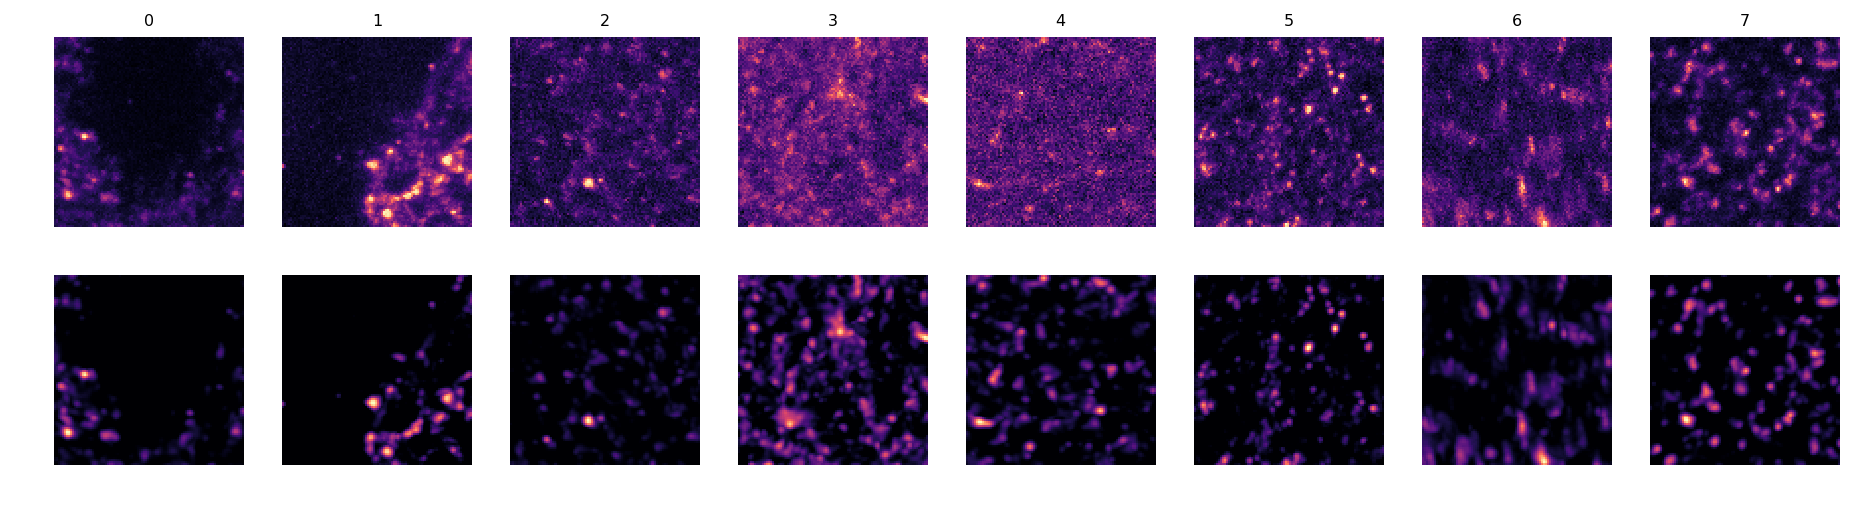

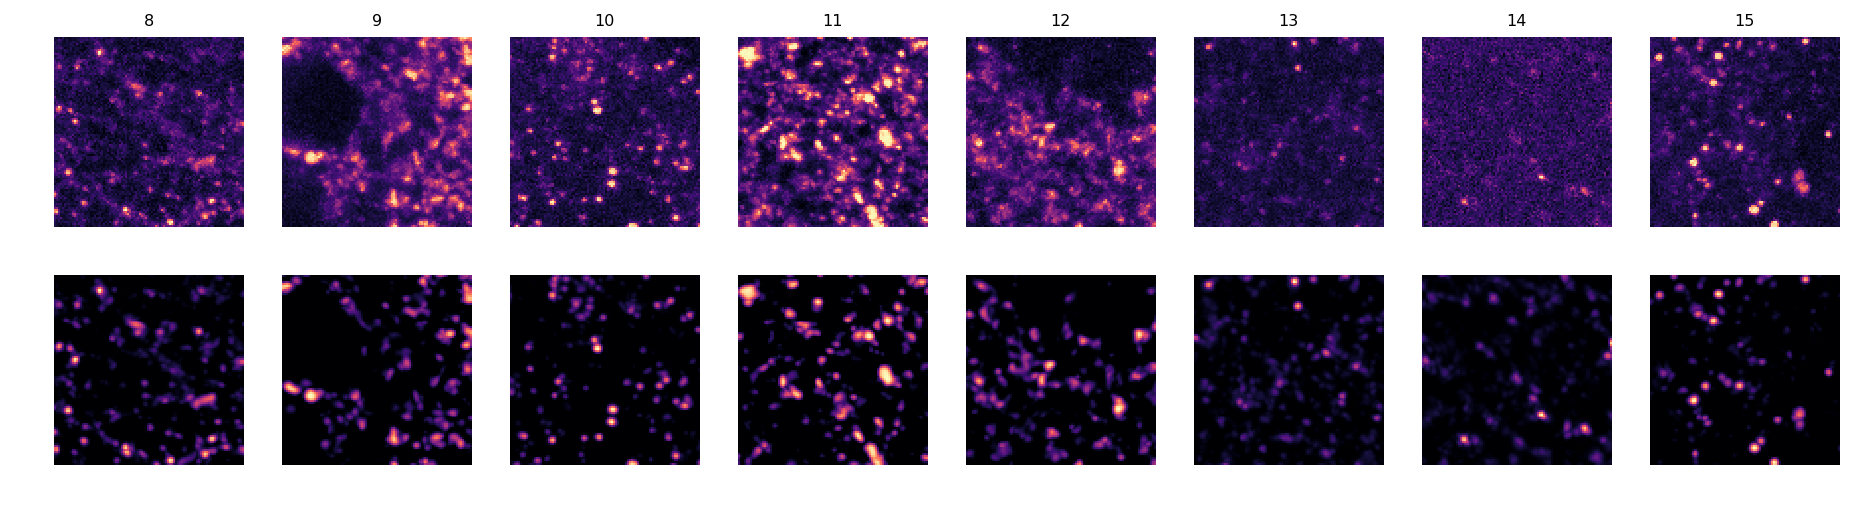

number of training images:	 109486
number of validation images:	 1106
image size (3D):		 (8, 96, 96)
axes:				 SZYXC
channels in / out:		 1 / 1
Config(axes='ZYXC', n_channel_in=1, n_channel_out=1, n_dim=3, probabilistic=False, train_batch_size=32, train_checkpoint='weights_best.h5', train_epochs=50, train_learning_rate=0.0008, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 3, 'min_delta': 0}, train_steps_per_epoch=100, train_tensorboard=True, u_net_n_first=32, unet_input_shape=(None, None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=3, unet_n_first=32, unet_residual=True)


c:\users\user\appdata\local\conda\conda\envs\tf-gpu\lib\site-packages\csbdeep\models\care_standard.py:114: UserWarning: output path for model already exists, files may be overwritten: C:\Users\User\Documents\GitHub\ErogluLab\csbdeep\models\Puncta
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


Epoch 1/50


KeyboardInterrupt: 

In [4]:
print("Creating patches")
model = input("Model Name? ")
raw_data = RawData.from_folder(basepath=directory, source_dirs=['LowRes1', 'LowRes2', 'LowRes3'], target_dir=directory+highres, axes='ZYX')

X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (8,96,96),
    n_patches_per_image = 128,
    # save_file           = 'data/' + name + '_data.npz',
)


# Two random flips
for i in range(1):
    for j in range(X.shape[0]):
        n = random.randint(0,2)
        if n == 0: # Do nothing
            pass
        else:
            X[i,0] = np.flip(X[i,0], n)
            Y[i,0] = np.flip(Y[i,0], n)
            
for j in range(X.shape[0]):
    n = random.randint(0,3)
    if n == 0: # Do nothing
        pass
    else:
        X[i,0] = np.rot90(X[i,0], n, (1,2))
        Y[i,0] = np.rot90(Y[i,0], n, (1,2))

for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;

(X,Y), (X_val,Y_val), axes = load_training_data_direct(X, Y, validation_split=0.01, verbose=True, axes='SCZYX')

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

config = Config(axes, n_channel_in,
                n_channel_out, train_steps_per_epoch=100, 
                unet_n_depth=3, u_net_n_first=32, train_batch_size=32,
                train_learning_rate=0.0008, train_epochs=50,
                train_reduce_lr={'factor':0.5, 'patience': 3, 'min_delta':0})
print(config)
vars(config)
model = CARE(config, model, basedir='models')
history = model.train(X,Y, validation_data=(X_val,Y_val))

Check that the image pairing matches.

Please input the model name in the cell below. The models are saved locally in <i>My Documents/csbdeep/models</i>.

<b>Be aware that the code will overwrite any existing model with the same name.</b>

Run the cell below to start training. Aim to train until the 'ReduceLROnPlateau' command shows up 3 times. Press the stop button to stop the training at any point.

In [ ]:
config = Config(axes, n_channel_in,
                n_channel_out, train_steps_per_epoch=200, 
                unet_n_depth=3, u_net_n_first=32, train_batch_size=32,
                train_learning_rate=0.0008, train_epochs=50,
                train_reduce_lr={'factor':0.5, 'patience': 3, 'min_delta':0})
print(config)
vars(config)
model = CARE(config, "Puncta", basedir='models')
history = model.train(X,Y, validation_data=(X_val,Y_val))

Config(axes='ZYXC', n_channel_in=1, n_channel_out=1, n_dim=3, probabilistic=False, train_batch_size=32, train_checkpoint='weights_best.h5', train_epochs=50, train_learning_rate=0.0008, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 3, 'min_delta': 0}, train_steps_per_epoch=200, train_tensorboard=True, u_net_n_first=32, unet_input_shape=(None, None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=3, unet_n_first=32, unet_residual=True)
Epoch 1/50
 - 121s - loss: 0.0708 - mse: 0.0158 - mae: 0.0708 - val_loss: 0.0325 - val_mse: 0.0046 - val_mae: 0.0325
Epoch 2/50
 - 125s - loss: 0.0304 - mse: 0.0039 - mae: 0.0304 - val_loss: 0.0274 - val_mse: 0.0033 - val_mae: 0.0274
Epoch 3/50
 - 124s - loss: 0.0268 - mse: 0.0031 - mae: 0.0268 - val_loss: 0.0305 - val_mse: 0.0037 - val_mae: 0.0305
Epoch 4/50
 - 123s - loss: 0.0250 - mse: 0.0029 - mae: 0.0250 - val_loss: 0.0218 - val_mse: 0.0027 - val_mae: 0.0218
Epoch 5/50
 - 123s - loss: 0.0243 - mse: 0.0029 - mae:

## And you're done!

Don't forget the to shutdown this file before running something else.

In [17]:
Y.shape

(704, 1, 8, 64, 64)

In [23]:
import random
print(random.randint(0,3))

0


In [81]:
x = imread('C:/Users/User/Desktop/Substack.tif')

In [82]:
x.shape

(15, 1024, 1024)

In [60]:
np.rot90(A[0])

array([[1, 3],
       [0, 2]])

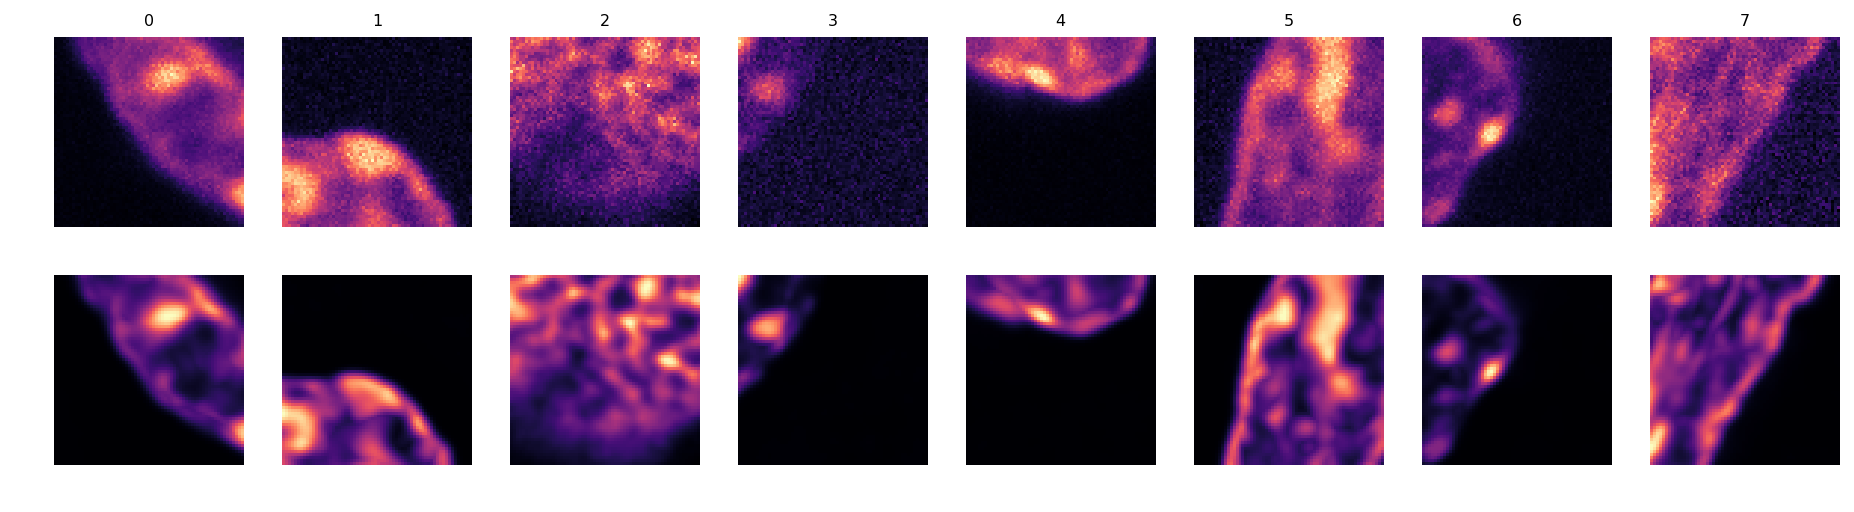

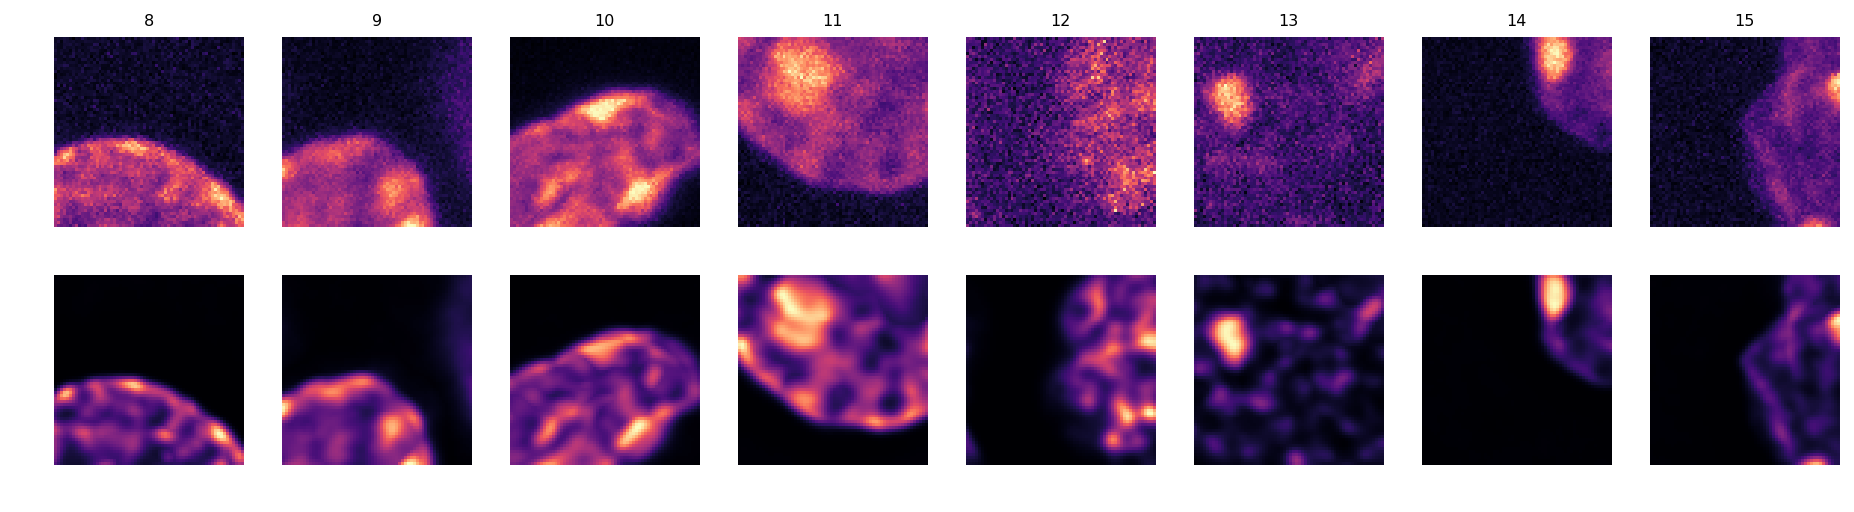

In [66]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;